# K-Nearest Neighbors (KNN): Theory & Application

## 1) The Theory: Finding the Nearest Neighbors

The K-nearest neighbors algorithm uses the following steps to classify a given prediction:

1. **Compute the Distance**:
   Decide on a distance metric (e.g., Euclidean distance) beforehand. For each data point *i* in the training set, calculate the distance between the test point and every feature vector *j*:
   $$d(x_{\text{test}}, x_i) = \sqrt{\sum_{j=1}^n (x_{\text{test}, j} - x_{i, j})^2} = \| x_{\text{test}} - x_i \|_2$$
   where:
   - *$x_{\text{test}}$* is the test point.
   - *$x_{\text{i}}$* is a training point.
   - *j* is a feature.
   - *n* is the number of features.

2. **Repeat for All Points**:
   Perform the distance calculation for all \(i\) points in the training dataset.

3. **Calculate Conditional Probabilities**:
   For each class label \(y\), calculate the conditional probability that the test point belongs to that label given the \(k\)-nearest neighbors:
   $$P(y = j \mid \text{neighbors}) = \frac{1}{k} \sum_{i=1}^k \mathbb{I}(y_i = j)$$
   where:
   - $\mathbb{I}(y_i = j)$ is the indicator function, which equals 1 if $y_i = j$ (the neighbor belongs to class *j* and 0 otherwise.
   - *k* is the number of neighbors.

4. **Choose the Label with Maximum Probability**:
   Select the label *j* that maximizes the conditional probability:
   $$\hat{y} = \arg\max_{j} P(y = j \mid \text{neighbors})$$
   The test point is assigned the class label corresponding to the highest conditional probability.


Let's go through a basic classification example.

In [1]:
import numpy as np
import pandas as pd

**We'll gather some data and split between features and labels.**

In [2]:
features = [[1, 2], [3, 4], [5, 6]]
labels = [1, 2, 1]

# Convert features list to numpy array and create DataFrame
features_array = np.array(features)
df = pd.DataFrame(features_array, columns=['feature1', 'feature2'])

# Add labels column
df['label'] = labels
print(df)

   feature1  feature2  label
0         1         2      1
1         3         4      2
2         5         6      1


**Specify our test point for classification.**

In [3]:
x_test = np.array([10, 12])

**Find the euclidean distance between that point with all other points and each of their features.**

In [4]:
features = df.drop('label', axis=1)
for i in range(len(df)):
    dist = np.linalg.norm(x_test-features.iloc[i])
    df.loc[i, 'dist'] = dist 
    
print(df)

   feature1  feature2  label       dist
0         1         2      1  13.453624
1         3         4      2  10.630146
2         5         6      1   7.810250


**We'll specify the "k" in k-nearest neighbors to decide *which* neighbors we should use for our algorithm.**

In [5]:
k = 1

# We are taking the highest 1 data point for classification

**Finally, we alculate and choose the label with the maximum (conditional) probability as our classification.**

In [6]:
# First sort the dataframe by distance to get nearest neighbor
df_sorted = df.sort_values('dist')

# For k=1, we only look at the first row (nearest neighbor)
nearest_label = df_sorted.iloc[0]['label']

# Create indicator function
def indicator(nearest_label):
    label_1 = 0  # Use integers instead of lists
    label_2 = 0
    
    if nearest_label == 1:
        label_1 = 1
    elif nearest_label == 2:
        label_2 = 1
        
    return {1: label_1, 2: label_2}  # Return a dictionary mapping labels to counts

# Get the counts
label_counts = indicator(nearest_label)

# Find the label with maximum count
classification = max(label_counts, key=label_counts.get)

print(f"Label counts: {label_counts}")
print(f"Classification: {classification}")

Label counts: {1: 1, 2: 0}
Classification: 1


Our point should be classified with the label "1" according to KNN.

## 2) The Application: Diagnosing Breast Cancer

In [53]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahmasleam/breast-cancer")

print("Path to dataset files:", path)

Path to dataset files: /Users/alexdubro/.cache/kagglehub/datasets/rahmasleam/breast-cancer/versions/1


Let's import the necessary packages.

Scikit-Learn will do all the heavy lifting that was laid out in the theory. We need to decide on which $k$, however, fits this problem.

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [55]:
dataset_path = os.path.join(path, 'breast-cancer.csv')

raw_data = pd.read_csv(dataset_path)
raw_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We know that M is "Malignant" and B is "Benign." Let's turn those into our label by assigning:
- M = 1
- B = 0

In [56]:
raw_data['diagnosis'] = raw_data['diagnosis'].map({'M': 1, 'B': 0})

Let's split the dataset up into training and test. The training set can be used to predict each test point, as we saw in the theory. Since KNN is an instance-based algorithm, the test points will be evaluated on a case-by-case basis.

In [57]:
features = raw_data.drop(['diagnosis'], axis=1)
label = raw_data['diagnosis']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=10)

Because of the sheer difference in size between each column's values (i.e. one column's values might be in thousands; another in decimals), let's standardize the values.

In [59]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Now, let's run KNN, and we'll have $k$ be variable.

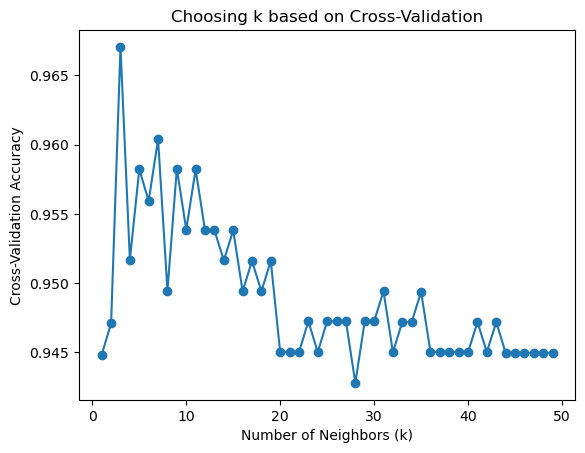

Optimal k: 3


In [74]:
# Range of k values to test
k_values = range(1, 50)
cv_scores = []

# Evaluate cross-validation accuracy for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot results
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Choosing k based on Cross-Validation')
plt.show()

# Best k
best_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Optimal k: {best_k}")

Cross validation indicates that the optimal k is 3.

Let's try accuracy and the F1 score.

In [70]:
def accuracy_knn(X_train, X_test, y_train, y_test, max_k=50):     
    train_scores = []     
    test_scores = []      
        
    for k in range(1, max_k + 1):         
        # Create and train KNN classifier         
        knn = KNeighborsClassifier(n_neighbors=k)         
        knn.fit(X_train, y_train)                  
        # Calculate scores         
        train_score = knn.score(X_train, y_train)         
        test_score = knn.score(X_test, y_test)                  
        train_scores.append(train_score)         
        test_scores.append(test_score)          
    
    return train_scores, test_scores  

# Perform evaluation 
train_accuracy_scores, test_accuracy_scores = accuracy_knn(X_train, X_test, y_train, y_test)

In [71]:
# Find the differences between train and test scores
differences = [abs(train - test) for train, test in zip(train_accuracy_scores, test_accuracy_scores)]

# Find the k value (adding 1 since k starts at 1) where difference is smallest
best_k = differences.index(min(differences)) + 1

print(f"Best k: {best_k}")
print(f"Train accuracy score: {train_accuracy_scores[best_k-1]:.4f}")
print(f"Test accuracy score: {test_accuracy_scores[best_k-1]:.4f}")
print(f"Difference: {differences[best_k-1]:.4f}")

Best k: 3
Train accuracy score: 0.9780
Test accuracy score: 0.9825
Difference: 0.0044


In [82]:
def accuracy_knn(X_train, X_test, y_train, y_test, max_k=50):
    train_scores = []
    test_scores = []
    
    for k in range(1, max_k + 1):
        # Create and train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Get predictions for both train and test sets
        train_pred = knn.predict(X_train)
        test_pred = knn.predict(X_test)
        
        # Calculate F1 scores
        train_score = accuracy_score(y_train, train_pred)
        test_score = accuracy_score(y_test, test_pred)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return train_scores, test_scores

# Example usage:
train_f1_scores, test_f1_scores = accuracy_knn(X_train, X_test, y_train, y_test)

# To find the best k value based on test F1 score:
best_k = test_f1_scores.index(max(test_f1_scores)) + 1
print(f"Best k value: {best_k}")
print(f"Best F1 score on test set: {max(test_f1_scores):.4f}")

# Optional: To compare specific k values
def compare_k_values(k_values, test_f1_scores):
    for k in k_values:
        print(f"k={k}: F1 Score = {test_f1_scores[k-1]:.4f}")

# Example: Compare k=3 and k=10
compare_k_values([3, 10], test_f1_scores)

Best k value: 5
Best F1 score on test set: 0.9912
k=3: F1 Score = 0.9825
k=10: F1 Score = 0.9737


In [83]:
# After you get your scores from the f1_knn function:
train_f1_scores, test_f1_scores = accuracy_knn(X_train, X_test, y_train, y_test)

# To find best k and show both scores
for k in range(len(test_f1_scores)):
    print(f"k={k+1}: Train F1={train_f1_scores[k]:.4f}, Test F1={test_f1_scores[k]:.4f}, "
          f"Difference={abs(train_f1_scores[k] - test_f1_scores[k]):.4f}")

# Find k with smallest difference and high scores
differences = [abs(train - test) for train, test in zip(train_f1_scores, test_f1_scores)]
best_k = differences.index(min(differences)) + 1

print(f"\nBest k value (smallest difference): {best_k}")
print(f"Train F1: {train_f1_scores[best_k-1]:.4f}")
print(f"Test F1: {test_f1_scores[best_k-1]:.4f}")
print(f"Difference: {differences[best_k-1]:.4f}")

k=1: Train F1=1.0000, Test F1=0.9825, Difference=0.0175
k=2: Train F1=0.9648, Test F1=0.9737, Difference=0.0088
k=3: Train F1=0.9780, Test F1=0.9825, Difference=0.0044
k=4: Train F1=0.9736, Test F1=0.9825, Difference=0.0088
k=5: Train F1=0.9780, Test F1=0.9912, Difference=0.0132
k=6: Train F1=0.9648, Test F1=0.9825, Difference=0.0176
k=7: Train F1=0.9648, Test F1=0.9825, Difference=0.0176
k=8: Train F1=0.9604, Test F1=0.9825, Difference=0.0220
k=9: Train F1=0.9626, Test F1=0.9912, Difference=0.0286
k=10: Train F1=0.9604, Test F1=0.9737, Difference=0.0132
k=11: Train F1=0.9626, Test F1=0.9912, Difference=0.0286
k=12: Train F1=0.9604, Test F1=0.9825, Difference=0.0220
k=13: Train F1=0.9626, Test F1=0.9912, Difference=0.0286
k=14: Train F1=0.9538, Test F1=0.9825, Difference=0.0286
k=15: Train F1=0.9538, Test F1=0.9825, Difference=0.0286
k=16: Train F1=0.9538, Test F1=0.9825, Difference=0.0286
k=17: Train F1=0.9538, Test F1=0.9825, Difference=0.0286
k=18: Train F1=0.9538, Test F1=0.9825, D

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

def f1_knn(X_train, X_test, y_train, y_test, max_k=50):
    train_scores = []
    test_scores = []
    
    for k in range(1, max_k + 1):
        # Create and train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Get predictions for both train and test sets
        train_pred = knn.predict(X_train)
        test_pred = knn.predict(X_test)
        
        # Calculate F1 scores
        train_score = f1_score(y_train, train_pred, average='macro')
        test_score = f1_score(y_test, test_pred, average='macro')
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return train_scores, test_scores

# Example usage:
train_f1_scores, test_f1_scores = f1_knn(X_train, X_test, y_train, y_test)

# To find the best k value based on test F1 score:
best_k = test_f1_scores.index(max(test_f1_scores)) + 1
print(f"Best k value: {best_k}")
print(f"Best F1 score on test set: {max(test_f1_scores):.4f}")

# Optional: To compare specific k values
def compare_k_values(k_values, test_f1_scores):
    for k in k_values:
        print(f"k={k}: F1 Score = {test_f1_scores[k-1]:.4f}")

# Example: Compare k=3 and k=10
compare_k_values([3, 10], test_f1_scores)

Best k value: 5
Best F1 score on test set: 0.9902
k=3: F1 Score = 0.9803
k=10: F1 Score = 0.9702


In [80]:
# After you get your scores from the f1_knn function:
train_f1_scores, test_f1_scores = f1_knn(X_train, X_test, y_train, y_test)

# To find best k and show both scores
for k in range(len(test_f1_scores)):
    print(f"k={k+1}: Train F1={train_f1_scores[k]:.4f}, Test F1={test_f1_scores[k]:.4f}, "
          f"Difference={abs(train_f1_scores[k] - test_f1_scores[k]):.4f}")

# Find k with smallest difference and high scores
differences = [abs(train - test) for train, test in zip(train_f1_scores, test_f1_scores)]
best_k = differences.index(min(differences)) + 1

print(f"\nBest k value (smallest difference): {best_k}")
print(f"Train F1: {train_f1_scores[best_k-1]:.4f}")
print(f"Test F1: {test_f1_scores[best_k-1]:.4f}")
print(f"Difference: {differences[best_k-1]:.4f}")

k=1: Train F1=1.0000, Test F1=0.9805, Difference=0.0195
k=2: Train F1=0.9620, Test F1=0.9702, Difference=0.0082
k=3: Train F1=0.9764, Test F1=0.9803, Difference=0.0039
k=4: Train F1=0.9716, Test F1=0.9803, Difference=0.0086
k=5: Train F1=0.9765, Test F1=0.9902, Difference=0.0137
k=6: Train F1=0.9621, Test F1=0.9803, Difference=0.0182
k=7: Train F1=0.9622, Test F1=0.9803, Difference=0.0181
k=8: Train F1=0.9572, Test F1=0.9803, Difference=0.0231
k=9: Train F1=0.9596, Test F1=0.9902, Difference=0.0306
k=10: Train F1=0.9572, Test F1=0.9702, Difference=0.0130
k=11: Train F1=0.9597, Test F1=0.9902, Difference=0.0305
k=12: Train F1=0.9573, Test F1=0.9803, Difference=0.0229
k=13: Train F1=0.9597, Test F1=0.9902, Difference=0.0305
k=14: Train F1=0.9500, Test F1=0.9803, Difference=0.0303
k=15: Train F1=0.9500, Test F1=0.9803, Difference=0.0303
k=16: Train F1=0.9499, Test F1=0.9803, Difference=0.0304
k=17: Train F1=0.9499, Test F1=0.9803, Difference=0.0304
k=18: Train F1=0.9499, Test F1=0.9803, D

In [78]:
# Find the differences between train and test scores
differences_f1_scores = [abs(train - test) for train, test in zip(train_f1_scores, test_f1_scores)]

# Find the k value (adding 1 since k starts at 1) where difference is smallest
best_k = differences_f1_scores.index(min(differences_f1_scores)) + 1

print(f"Best k: {best_k}")
print(f"Train f1 score: {train_f1_scores[best_k-1]:.4f}")
print(f"Test f1 score: {test_f1_scores[best_k-1]:.4f}")
print(f"Difference: {differences[best_k-1]:.4f}")

Best k: 3
Train f1 score: 0.9780
Test f1 score: 0.9825
Difference: 0.0044


46 46


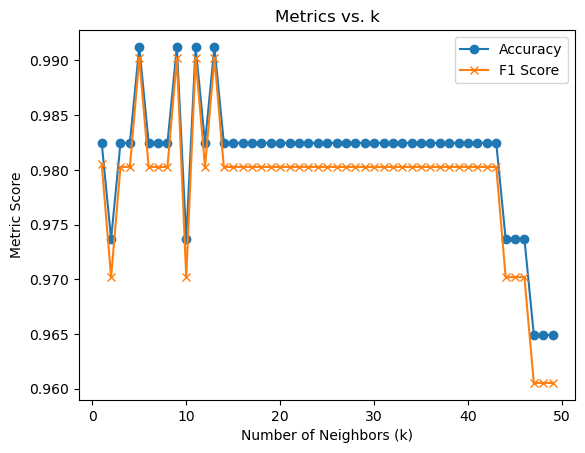

In [ ]:
# Evaluate multiple metrics for each k
k_values = range(1, 50)
accuracy_scores, f1_scores = [], []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))

# Plot accuracy and F1-score
plt.plot(k_values, accuracy_scores, label='Accuracy', marker='o')
plt.plot(k_values, f1_scores, label='F1 Score', marker='x')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Metric Score')
plt.title('Metrics vs. k')
plt.legend()
plt.show()

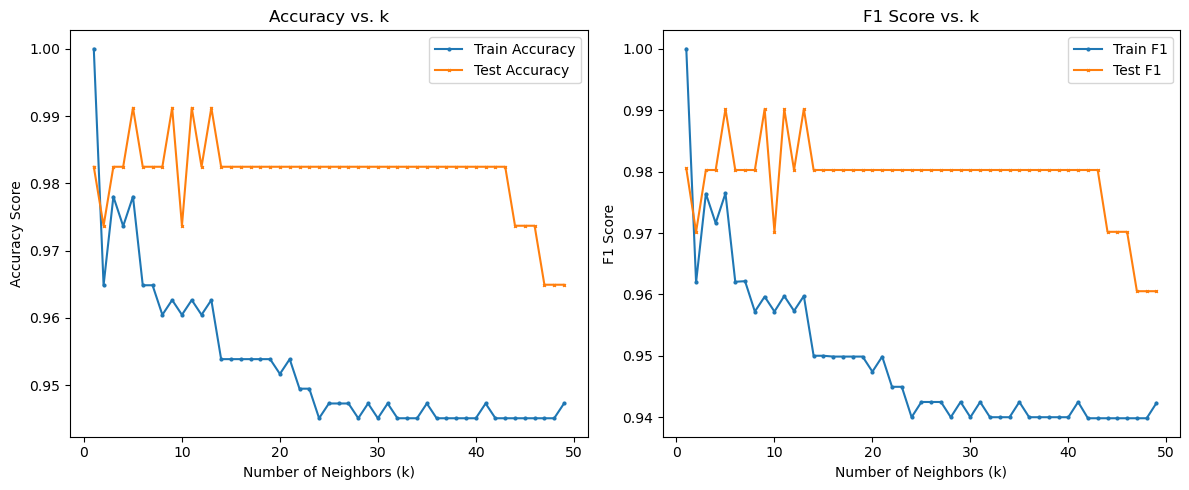

In [84]:
# Evaluate multiple metrics for each k
k_values = range(1, 50)
train_accuracy, test_accuracy = [], []
train_f1, test_f1 = [], []

for k in k_values:
    # Create and fit model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Get predictions for both sets
    train_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    
    # Calculate accuracy scores
    train_accuracy.append(accuracy_score(y_train, train_pred))
    test_accuracy.append(accuracy_score(y_test, test_pred))
    
    # Calculate F1 scores
    train_f1.append(f1_score(y_train, train_pred, average='macro'))
    test_f1.append(f1_score(y_test, test_pred, average='macro'))

# Create figure with two subplots
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(k_values, train_accuracy, label='Train Accuracy', marker='o', markersize=2)
plt.plot(k_values, test_accuracy, label='Test Accuracy', marker='x', markersize=2)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.title('Accuracy vs. k')
plt.legend()

# Plot F1 scores
plt.subplot(1, 2, 2)
plt.plot(k_values, train_f1, label='Train F1', marker='o', markersize=2)
plt.plot(k_values, test_f1, label='Test F1', marker='x', markersize=2)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. k')
plt.legend()

plt.tight_layout()
plt.show()

We get conflicting results here; accuracy and the F1 score point out that 3 and 10 are just as good as at predicting the algorithm. 

What matters just as much is how closely those two results are. Let's find out.

Let's find the differences between the accuracy values.

In [22]:
print(np.argmax(accuracy_scores))
print(np.argmax(f1_scores))

print(pd.Series(accuracy_scores))
# print(accuracy_scores)
# print(f1_scores)

4
4
0     0.982456
1     0.973684
2     0.982456
3     0.982456
4     0.991228
5     0.982456
6     0.982456
7     0.982456
8     0.991228
9     0.973684
10    0.991228
11    0.982456
12    0.991228
13    0.982456
14    0.982456
15    0.982456
16    0.982456
17    0.982456
18    0.982456
19    0.982456
20    0.982456
21    0.982456
22    0.982456
23    0.982456
24    0.982456
25    0.982456
26    0.982456
27    0.982456
28    0.982456
29    0.982456
30    0.982456
31    0.982456
32    0.982456
33    0.982456
34    0.982456
35    0.982456
36    0.982456
37    0.982456
38    0.982456
39    0.982456
40    0.982456
41    0.982456
42    0.982456
43    0.973684
44    0.973684
45    0.973684
46    0.964912
47    0.964912
48    0.964912
dtype: float64


In [50]:
# Find the differences between train and test scores
differences_accuracy = [abs(train - test) for train, test in zip(train_scores, test_scores)]

# Find the k value (adding 1 since k starts at 1) where difference is smallest
best_k = differences.index(min(differences)) + 1

print(f"Best k: {best_k}")
print(f"Train score: {train_scores[best_k-1]:.4f}")
print(f"Test score: {test_scores[best_k-1]:.4f}")
print(f"Difference: {differences[best_k-1]:.4f}")

Best k: 1
Train score: 1.0000
Test score: 0.9825
Difference: 0.0175


In [51]:
differences_f1_scores = [abs(train - test) for train, test in zip(train_scores, test_scores)]

# Find the k value (adding 1 since k starts at 1) where difference is smallest
best_k = differences.index(min(differences)) + 1

print(f"Best k: {best_k}")
print(f"Train score: {train_scores[best_k-1]:.4f}")
print(f"Test score: {test_scores[best_k-1]:.4f}")
print(f"Difference: {differences[best_k-1]:.4f}")

Best k: 1
Train score: 1.0000
Test score: 0.9825
Difference: 0.0175


In [52]:
# Find the differences between train and test scores
differences = [abs(train - test) for train, test in zip(train_scores, test_scores)]

# Find the k value (adding 1 since k starts at 1) where difference is smallest
best_k = differences.index(min(differences)) + 1

print(f"Best k: {best_k}")
print(f"Train score: {train_scores[best_k-1]:.4f}")
print(f"Test score: {test_scores[best_k-1]:.4f}")
print(f"Difference: {differences[best_k-1]:.4f}")

Best k: 1
Train score: 1.0000
Test score: 0.9825
Difference: 0.0175


Our best k is 3. This is our accuracy: ratio of correct predictions to total predictions.

Let's use k = 3 to fit our model.

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(y_pred)

[1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0
 0 1 1]


### Evaluating Metrics for KNN

We have already determined the **accuracy**, which helped us decide on #k = 3#. Now, let’s explore what the other metrics reveal:

#### Metrics Definitions
1. **Precision Score**:  
   Measures the proportion of correctly predicted positive observations to the total predicted positives. It indicates how precise the model's positive predictions are.  
   Formula:  
   $$\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$$

2. **Recall Score**:  
   Measures the proportion of correctly predicted positive observations to all actual positives. It evaluates the model's ability to capture all relevant cases.  
   Formula:  
   $$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}$$

3. **F1 Score**:  
   The harmonic mean of precision and recall. It balances the trade-off between precision and recall, especially when the dataset is imbalanced.  
   $$\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

4. **Confusion Matrix**:  
   A matrix summarizing the performance of a classification model. It consists of the following components:  
   - **True Positives (TP)**: Correctly predicted positive cases.  
   - **True Negatives (TN)**: Correctly predicted negative cases.  
   - **False Positives (FP)**: Incorrectly predicted positive cases.  
   - **False Negatives (FN)**: Incorrectly predicted negative cases.  

#### Confusion Matrix Overview
We'll include a **confusion matrix** to visualize the classification results:

|                     | Predicted Positive | Predicted Negative |
|---------------------|-------------------|-------------------|
| **Actual Positive** | True Positives (TP) | False Negatives (FN) |
| **Actual Negative** | False Positives (FP) | True Negatives (TN) |

#### Classification Report
Finally, we’ll consolidate all the metrics—accuracy, precision, recall, and F1 score—into a **classification report**, which provides a comprehensive summary in a readable format.


In [ ]:
# print("\nModel Performance Metrics:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print(f"Precision (Macro): {precision_score(y_test, y_pred, average='macro'):.4f}")
# print(f"Recall (Macro): {recall_score(y_test, y_pred, average='macro'):.4f}")
# print(f"F1 Score (Macro): {f1_score(y_test, y_pred, average='macro'):.4f}")

# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# print("\nDetailed Classification Report:")
# print(classification_report(y_test, y_pred))

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print results with explanations
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")


Model Performance Metrics:
Accuracy: 0.9825
Precision (Macro): 0.9870
Recall (Macro): 0.9744
F1 Score (Macro): 0.9803

Confusion Matrix:
Labels: Actual Positive, Actual Negative
[[75  0]
 [ 2 37]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        75
           1       1.00      0.95      0.97        39

    accuracy                           0.98       114
   macro avg       0.99      0.97      0.98       114
weighted avg       0.98      0.98      0.98       114



In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Labels: Actual Positive, Actual Negative")
print(conf_matrix)

Labels: Actual Positive, Actual Negative
[[75  0]
 [ 2 37]]


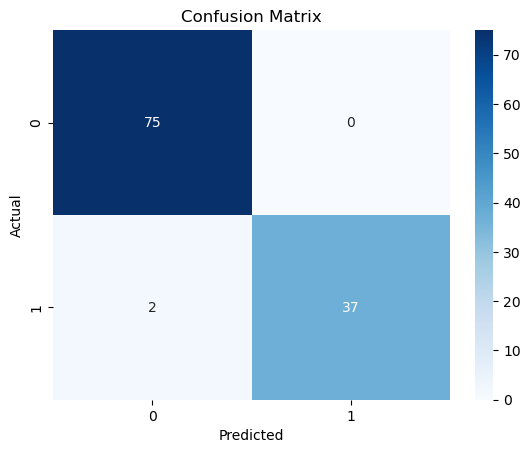

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [26]:
class_report = classification_report(y_test, y_pred)
print("\nDetailed Classification Report:")
print(class_report)


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        75
           1       1.00      0.95      0.97        39

    accuracy                           0.98       114
   macro avg       0.99      0.97      0.98       114
weighted avg       0.98      0.98      0.98       114

